# Generation of learning database from a stochastic reactors simulation

This notebook builds a database to be used as a training database for the ML algorithm. In order for this script to be used, a stochastic reactors simulation with *build_ML_dtb=True* must have neen run beforehand. This simulation produces files *X.csv* and *Y.csv* with raw states $T$, $Y_k$ and necessary information to clusterize or re-sample the data (e.g. progress variable, heat release rate,...). 

The current script generate the final database and enables to choose several options:

+ Prediction of $Y_k(t+dt)$ or $Y_k(t+dt)-Y_k(t)$

+ Application of a transform such as logarithm or Box-Cox

+ Possibility to apply a temperature threshold to the data to avoid non-reacting zones

+ Possibility to clusterize the data based on (i) k-means algorithm; (ii) progress variable values.

+ Re-sampling of the database: if the database is too imbalanced, a strategy based on heat release rate (HRR) may be used to focus the data on the regions of interest.

Files *X_train*, *Y_train*, *X_val* and *Y_val* are created for each cluster. Note that if no clustering is applied, the default single cluster is cluster 0.

## Data reading

In [1]:
from ai_reacting_flows.stochastic_reactors_data_gen.database_processing import LearningDatabase

In [2]:
%load_ext autoreload
%autoreload 2

The parameters of the database processing are first set:

In [3]:
# Dictionary to store data processing parameters
dtb_processing_parameters = {}

dtb_processing_parameters["dtb_folder"] = "../scripts/STOCH_DTB_HOTSPOT_H2_HRR"       # Stochastic reactors simulation folder
dtb_processing_parameters["database_name"] = "database_log_log_resampled"                   # Resulting database name
dtb_processing_parameters["log_transform_X"] = 1              # 0: no transform, 1: Logarithm transform, 2: Box-Cox transform
dtb_processing_parameters["log_transform_Y"] = 1              # 0: no transform, 1: Logarithm transform, 2: Box-Cox transform
dtb_processing_parameters["threshold"] = 1.0e-10            # Threshold to be applied in case of logarithm transform
dtb_processing_parameters["output_omegas"] = True          # True: output differences, False: output mass fractions
dtb_processing_parameters["detailed_mechanism"] = "/work/mehlc/2_IA_KINETICS/ai_reacting_flows/data/chemical_mechanisms/mech_H2.yaml"        # Mechanism used for the database generation (/!\ YAML format)
dtb_processing_parameters["fuel"] = "H2"           # Fuel name
dtb_processing_parameters["with_N_chemistry"] = False        # Considering Nitrogen chemistry or not (if not, N not considered in atom balance for reduction). In MLP, it will change treatment of N2.

The database is then created as a *LearningDatabase* object:

In [21]:
database = LearningDatabase(dtb_processing_parameters)

Opening solution: 0 / 5913
Opening solution: 100 / 5913
Opening solution: 200 / 5913
Opening solution: 300 / 5913
Opening solution: 400 / 5913
Opening solution: 500 / 5913
Opening solution: 600 / 5913
Opening solution: 700 / 5913
Opening solution: 800 / 5913
Opening solution: 900 / 5913
Opening solution: 1000 / 5913
Opening solution: 1100 / 5913
Opening solution: 1200 / 5913
Opening solution: 1300 / 5913
Opening solution: 1400 / 5913
Opening solution: 1500 / 5913
Opening solution: 1600 / 5913
Opening solution: 1700 / 5913
Opening solution: 1800 / 5913
Opening solution: 1900 / 5913
Opening solution: 2000 / 5913
Opening solution: 2100 / 5913
Opening solution: 2200 / 5913
Opening solution: 2300 / 5913
Opening solution: 2400 / 5913
Opening solution: 2500 / 5913
Opening solution: 2600 / 5913
Opening solution: 2700 / 5913
Opening solution: 2800 / 5913
Opening solution: 2900 / 5913
Opening solution: 3000 / 5913
Opening solution: 3100 / 5913
Opening solution: 3200 / 5913
Opening solution: 3300

## Data simple filtering

We can apply in a first step some simple filters to reduce the size of the dataset. Reducing the number of data points at this early stage leads to faster database treatment and may be recommended. 

We can for instance apply a temperature threshold, here $600$ K for instance:

In [22]:
database.apply_temperature_threshold(600.0)

## Reduction of the species space

We have the possibility to apply ANN only to a reduced subset of species. In order to preserve atomic masses and enthalpy, a set of fictive species is added to the database. Their mass fractions are computed so that conservation of quantities is ensured. In order for the problem to have a solution, the following rules must be obeyed when selecting the fictive species:

+ The number of fictive species must be *number of atoms + 1* (for the enthalpy). At the moment, the number of atoms is 4 ($C$, $H$, $O$, $N$), except for $H_2$, where carbon is not considered. Another possibility is to discard $N$, this is done by setting the *with_N_chemistry* parameter above to *False*.

+ Each atom must be represented at least once.

The reduction operation can be done with the following lines:

In [ ]:
fictive_species = ["O2", "H2O", "CO2", "CH4"]
subset_species = ["N2", "O2", "H2O", "CO2", "CH4", "CO"]
database.reduce_species_set(subset_species, fictive_species)

We can for instance check that the sum of species mass fractions is 1:

In [ ]:
print(database.X[subset_species + [spec+"_F" for spec in fictive_species]].sum(axis=1))

Note that the check for the sum being 1 is here just illustrative, as an advanced verification on the individual atomic mass fractions and the enthalpy is made in the *reduce_species_set* routine.

## Data re-sampling

In order to reach an adequate data distribution we might need to perform a re-sampling of the data. This could happen for instance when in the stochastic particles database a lot of particles are at the equilibrium state. The points of interest are the points where the HRR is high and are usually fewer in the initial database. 

In order to diagnosis the issue, we can analyze the joint probability density function (PDF) of two variables and the PDF of one variable:

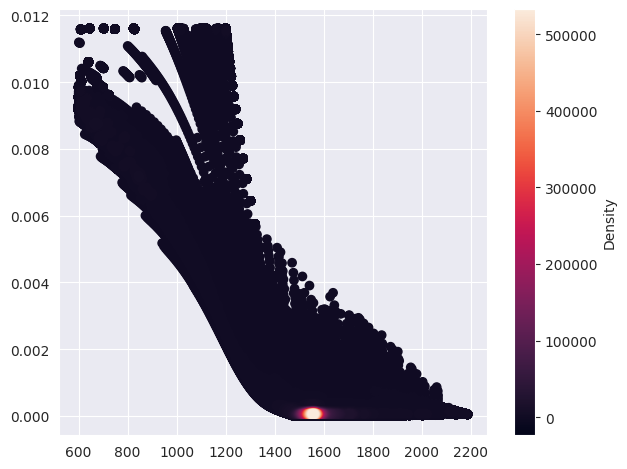

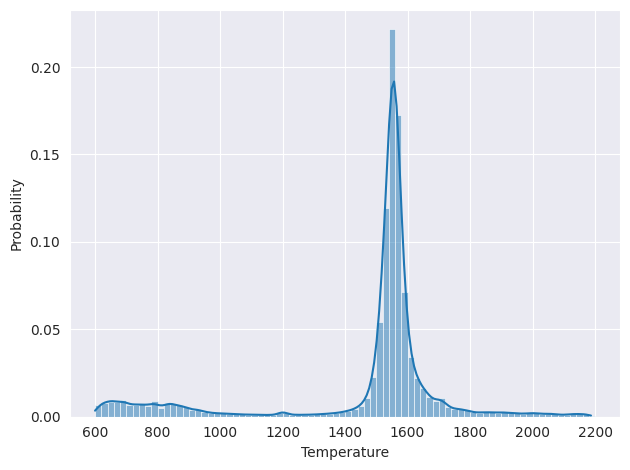

In [80]:
database.density_scatter("Temperature" , "H2", sort = True, bins = 100)

database.plot_pdf_var("Temperature")

The methodology proposed here to perform data re-sampling is based on heat release rate. The idea is to promote points with high HRR in the database, and penalize the presence of points with high density in the initial database along with low HRR. The methodology is taken from the paper of [Chi et al.](https://www.sciencedirect.com/science/article/pii/S0010218022003406). We note $|\dot{q}_i|^n$ the min-max normalized norm of the absolute HRR of sample $i$. We consider two variables $\psi_1$ and $\psi_2$ for which marginal PDFs will be computed.

For a given sample $\mathbf{x}$, the sampling PDF, conditioned on $\psi_1$ and $\psi_2$, is written $f_s(\mathbf{x})$.

A PDF for the HRR is then built by considering the distribution of HRR conditioned on $\psi_1$ and $\psi_2$. The variable for which the PDF is built is here is $a=1+\alpha |\dot{q}_i|^n$, as it helps to focus the point selection in the flame region. In practice, we consider bins in $\psi_1$ and $\psi_2$ space and then compute the averaged $a$ of particles in each bins. This gives us a PDF $f_q(\mathbf{x})$. The weighting function for the re-sampling is then defined as

$$
f_m(\mathbf{x}) = \frac{N_s}{N}\frac{f_q(\mathbf{x})}{f_s(\mathbf{x})}
$$

where $N$ is the total number of samples from the initial database and $N_s$ the number of sample in the new database. $N_s$ can me estimated using the following relationship:

$$
N_s f_q(\mathbf{x})|_{\mathbf{x}=\mathbf{X}} = N f_s(\mathbf{x})|_{\mathbf{x}=\mathbf{X}}
$$

where $\mathbf{X}$ is the location of the peak HRR.

The procedure may be applied to our database as follows:

In [24]:
database.undersample_HRR("Temperature", "H2", n_bins = 100, n_samples = 500000)

/work/mehlc/2_IA_KINETICS/ai_reacting_flows/ai_reacting_flows/stochastic_reactors_data_gen/database_processing.py:285: RuntimeWarning: invalid value encountered in divide
  data_hrr = data_hrr / counts
/work/mehlc/2_IA_KINETICS/ai_reacting_flows/ai_reacting_flows/stochastic_reactors_data_gen/database_processing.py:298: RuntimeWarning: invalid value encountered in divide
  f_m = (n_samples/n) * (data_hrr/data)
/work/mehlc/2_IA_KINETICS/ai_reacting_flows/ai_reacting_flows/stochastic_reactors_data_gen/database_processing.py:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_save[X_save["Prog_var"]<0.2]["p"] = 1.0  # very large weight



 Number of points in undersampled dataset: 500000 

    >> 17.80954049960748 % of the database is retained


The new joint PDF and PDF can then be checked:

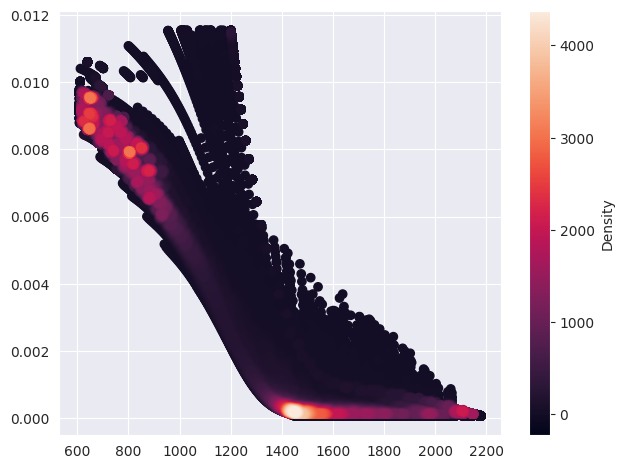

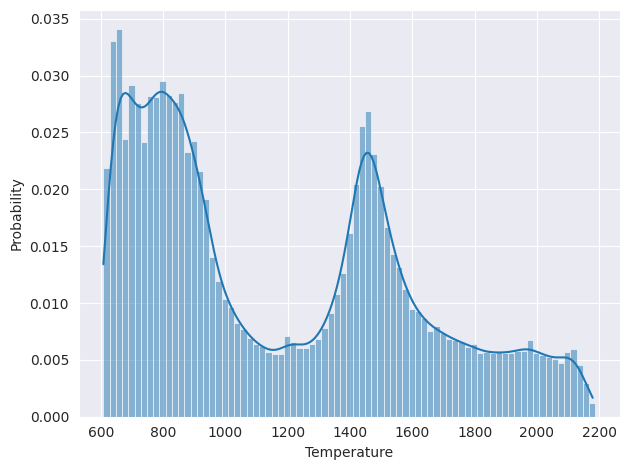

In [25]:
database.density_scatter("Temperature" , "H2", sort = True, bins = 100)

database.plot_pdf_var("Temperature")

We can check also the size of the database:

In [50]:
database.print_data_size()

>> There are 100000 points in cluster0

 => There are 100000 points overall


## Dataset clustering

We can clusterize the dataset based on a progress variable if needed:

In [8]:
database.clusterize_dataset("progvar", 2, c_bounds=[0,0.95,1.0])

Alternatively, we could have used k-means: (commented because double clustering is banned)

In [94]:
database.clusterize_dataset("kmeans", 3)

>> Performing k-means clustering


We can visualize the cluster:

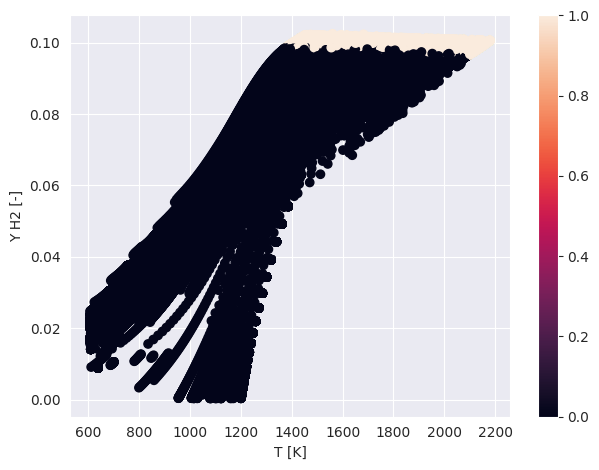

In [71]:
database.visualize_clusters("H2O")

We can print the size of the database (count made for each cluster):

In [72]:
database.print_data_size()

>> There are 181285 points in cluster0
>> There are 18715 points in cluster1

 => There are 200000 points overall


## Database processing

Finally, the database is processed in order ot be used in ML pipeline: (useless dataframe columns are suppressed and the transformation of the data is performed)


CLUSTER 0:
>> Saving datasets
>> Plotting distributions

CLUSTER 1:
>> Saving datasets
>> Plotting distributions


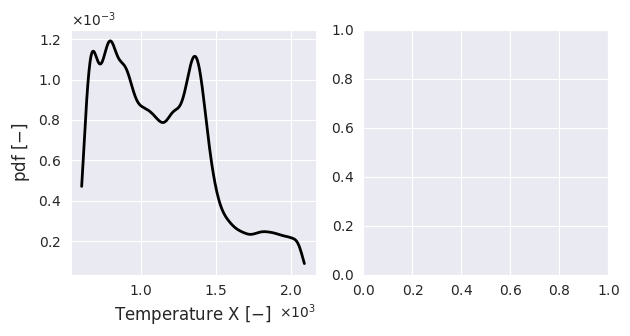

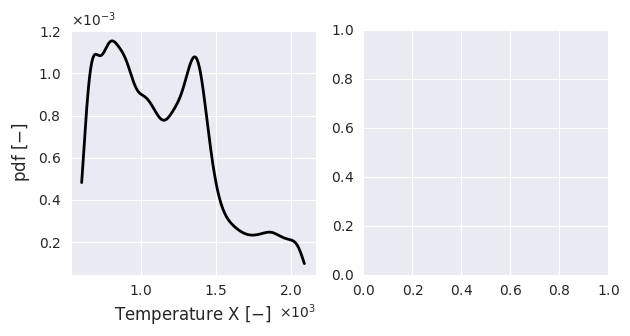

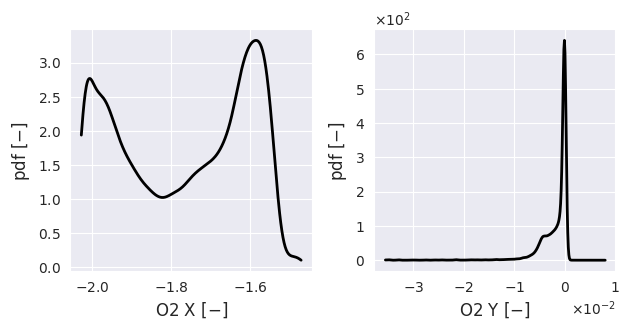

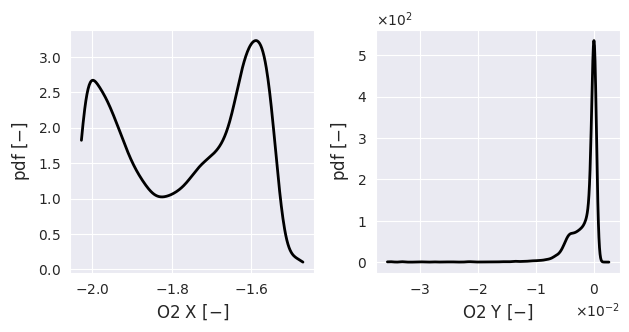

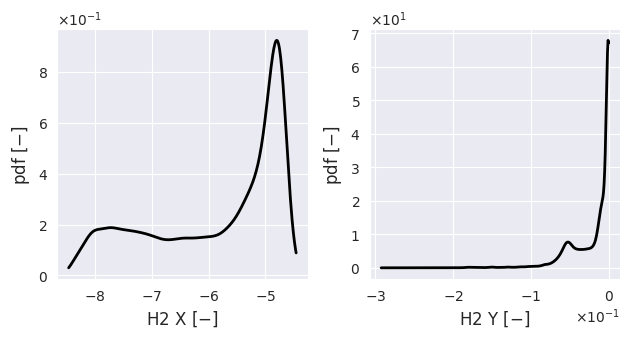

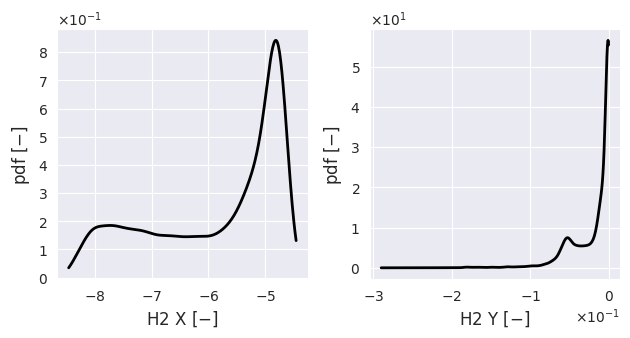

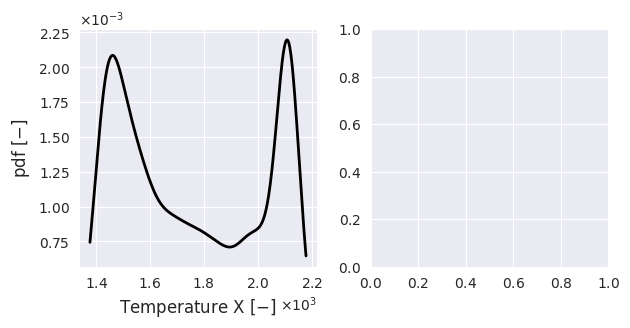

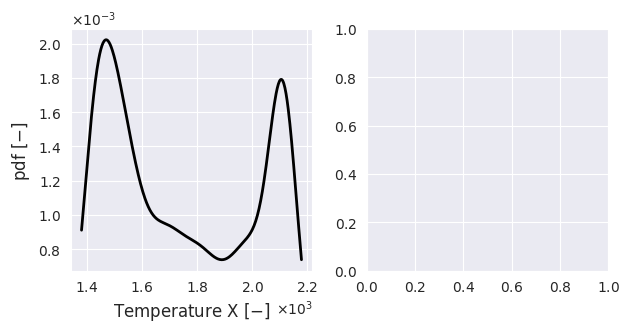

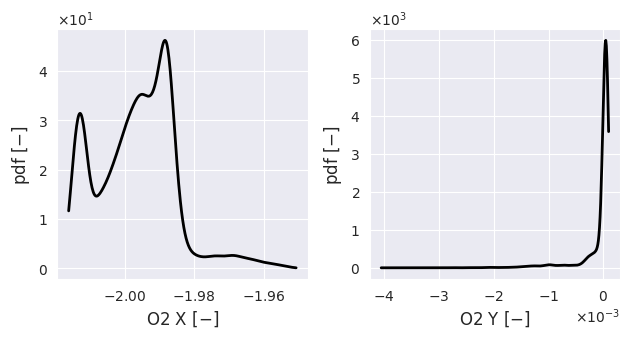

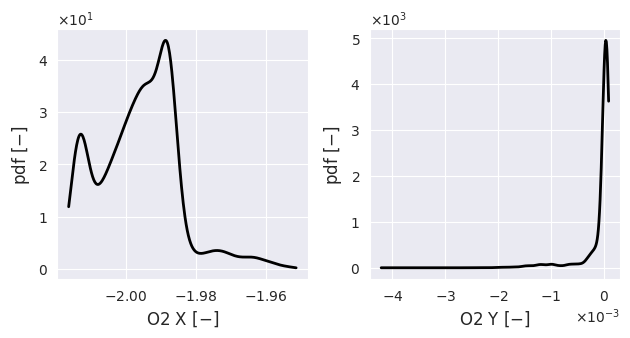

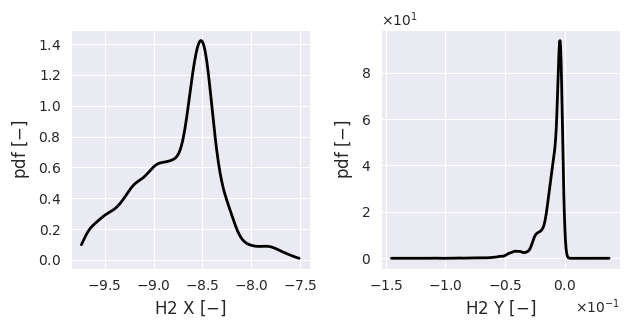

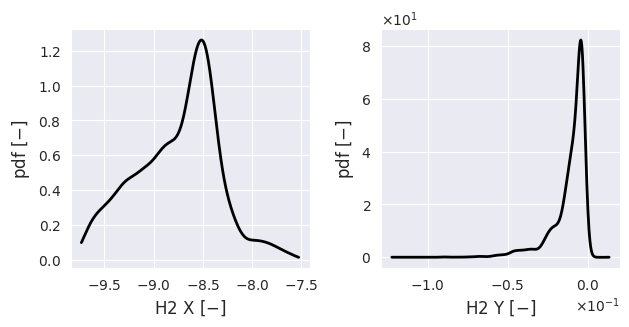

In [9]:
database.process_database(plot_distributions = True, distribution_species=["Temperature", "O2", "H2"])